In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import warnings

In [2]:
tips = pd.read_csv("./data/tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,Payer Name,CC Number,Payment ID
239,29.03,5.92,Male,No,Sat,Dinner,3,9.68,Michael Avila,5296068606052842,Sat2657
240,27.18,2.00,Female,Yes,Sat,Dinner,2,13.59,Monica Sanders,3506806155565404,Sat1766
241,22.67,2.00,Male,Yes,Sat,Dinner,2,11.34,Keith Wong,6011891618747196,Sat3880
242,17.82,1.75,Male,No,Sat,Dinner,2,8.91,Dennis Dixon,4375220550950,Sat17
243,18.78,3.00,Female,No,Thur,Dinner,2,9.39,Michelle Hardin,3511451626698139,Thur672


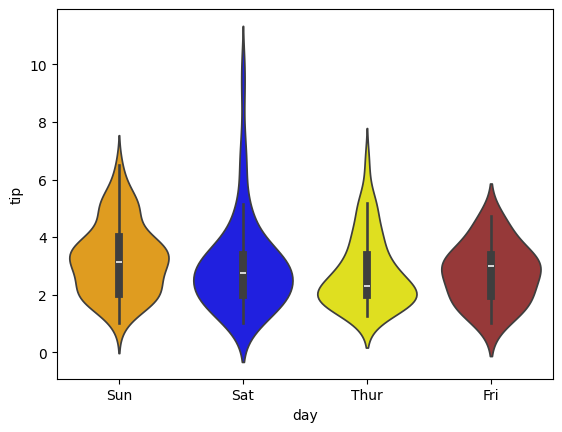

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.violinplot(
        x='day', y='tip', data=tips, palette=[
        "orange", "blue", "yellow", "brown"]
        )
    plt.show()

In [4]:
tip = tips['tip'].values
idx = pd.Categorical(
    tips["day"], categories=[
    'Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))
group_names = np.unique(tips["day"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


/opt/homebrew/Caskroom/miniconda/base/envs/bayes/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

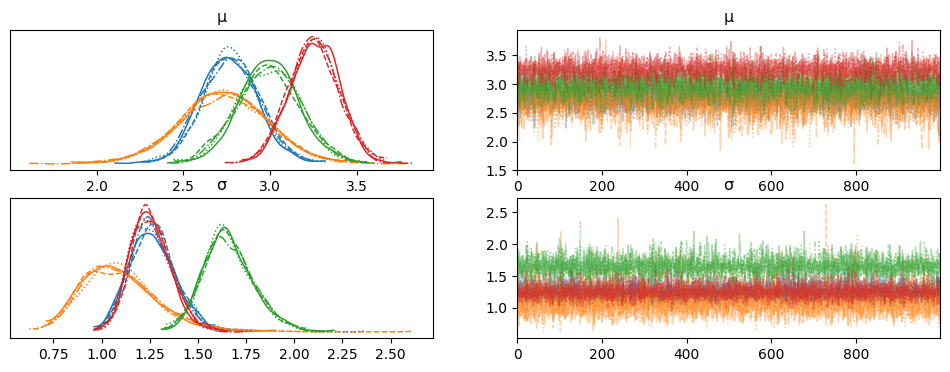

In [5]:
with pm.Model() as model:
    μ = pm.Normal('μ', mu=0, sigma=10, shape=groups)
    σ = pm.HalfNormal('σ', sigma=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=tip)

    trace_cg = pm.sample(1000, tune=1000)
    
az.plot_trace(trace_cg)

Показывает:

Trace plot — как менялись параметры на каждой итерации.

Posterior plot — распределение параметров после сэмплирования.

---
Таблица с основными статистиками:

mean: среднее значение апостериорного распределения

sd: стандартное отклонение

hdi_3% и hdi_97%: 94% доверительный интервал (в байесовском смысле — HDI — Highest Density Interval)

In [6]:
az.summary(trace_cg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],2.771,0.164,2.454,3.071,0.002,0.003,4317.0,3027.0,1.0
μ[1],2.733,0.255,2.240,3.189,0.004,0.004,3999.0,2980.0,1.0
μ[2],2.992,0.178,2.649,3.319,0.003,0.003,4416.0,2659.0,1.0
μ[3],3.255,0.142,2.988,3.517,0.002,0.002,4506.0,3186.0,1.0
σ[0],1.266,0.117,1.059,1.491,0.002,0.002,4703.0,2711.0,1.0
σ[1],1.098,0.202,0.740,1.447,0.003,0.004,4632.0,2992.0,1.0
σ[2],1.659,0.130,1.409,1.900,0.002,0.002,4778.0,2973.0,1.0
σ[3],1.256,0.104,1.070,1.454,0.001,0.002,5305.0,3270.0,1.0


---
График плотности апостериорного распределения:

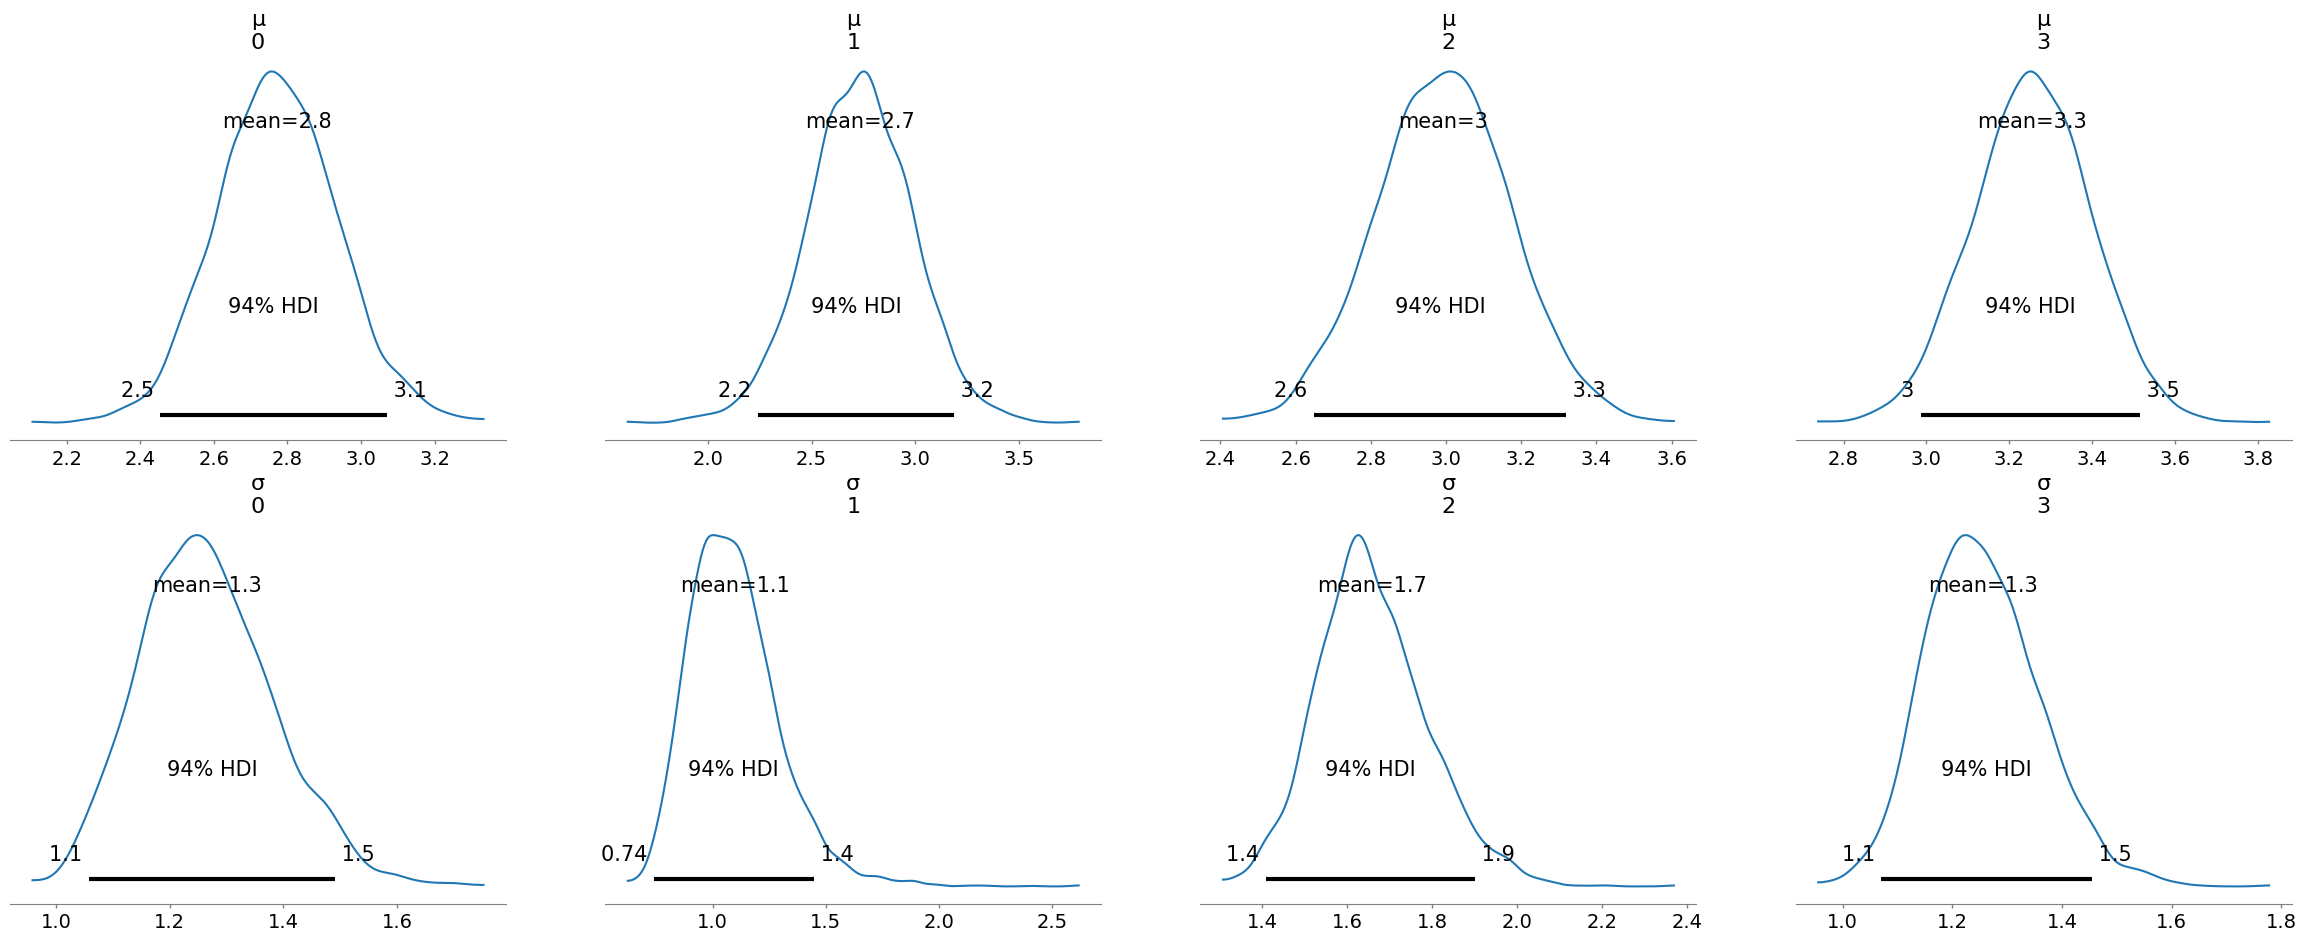

In [7]:
az.plot_posterior(trace_cg)
plt.show()

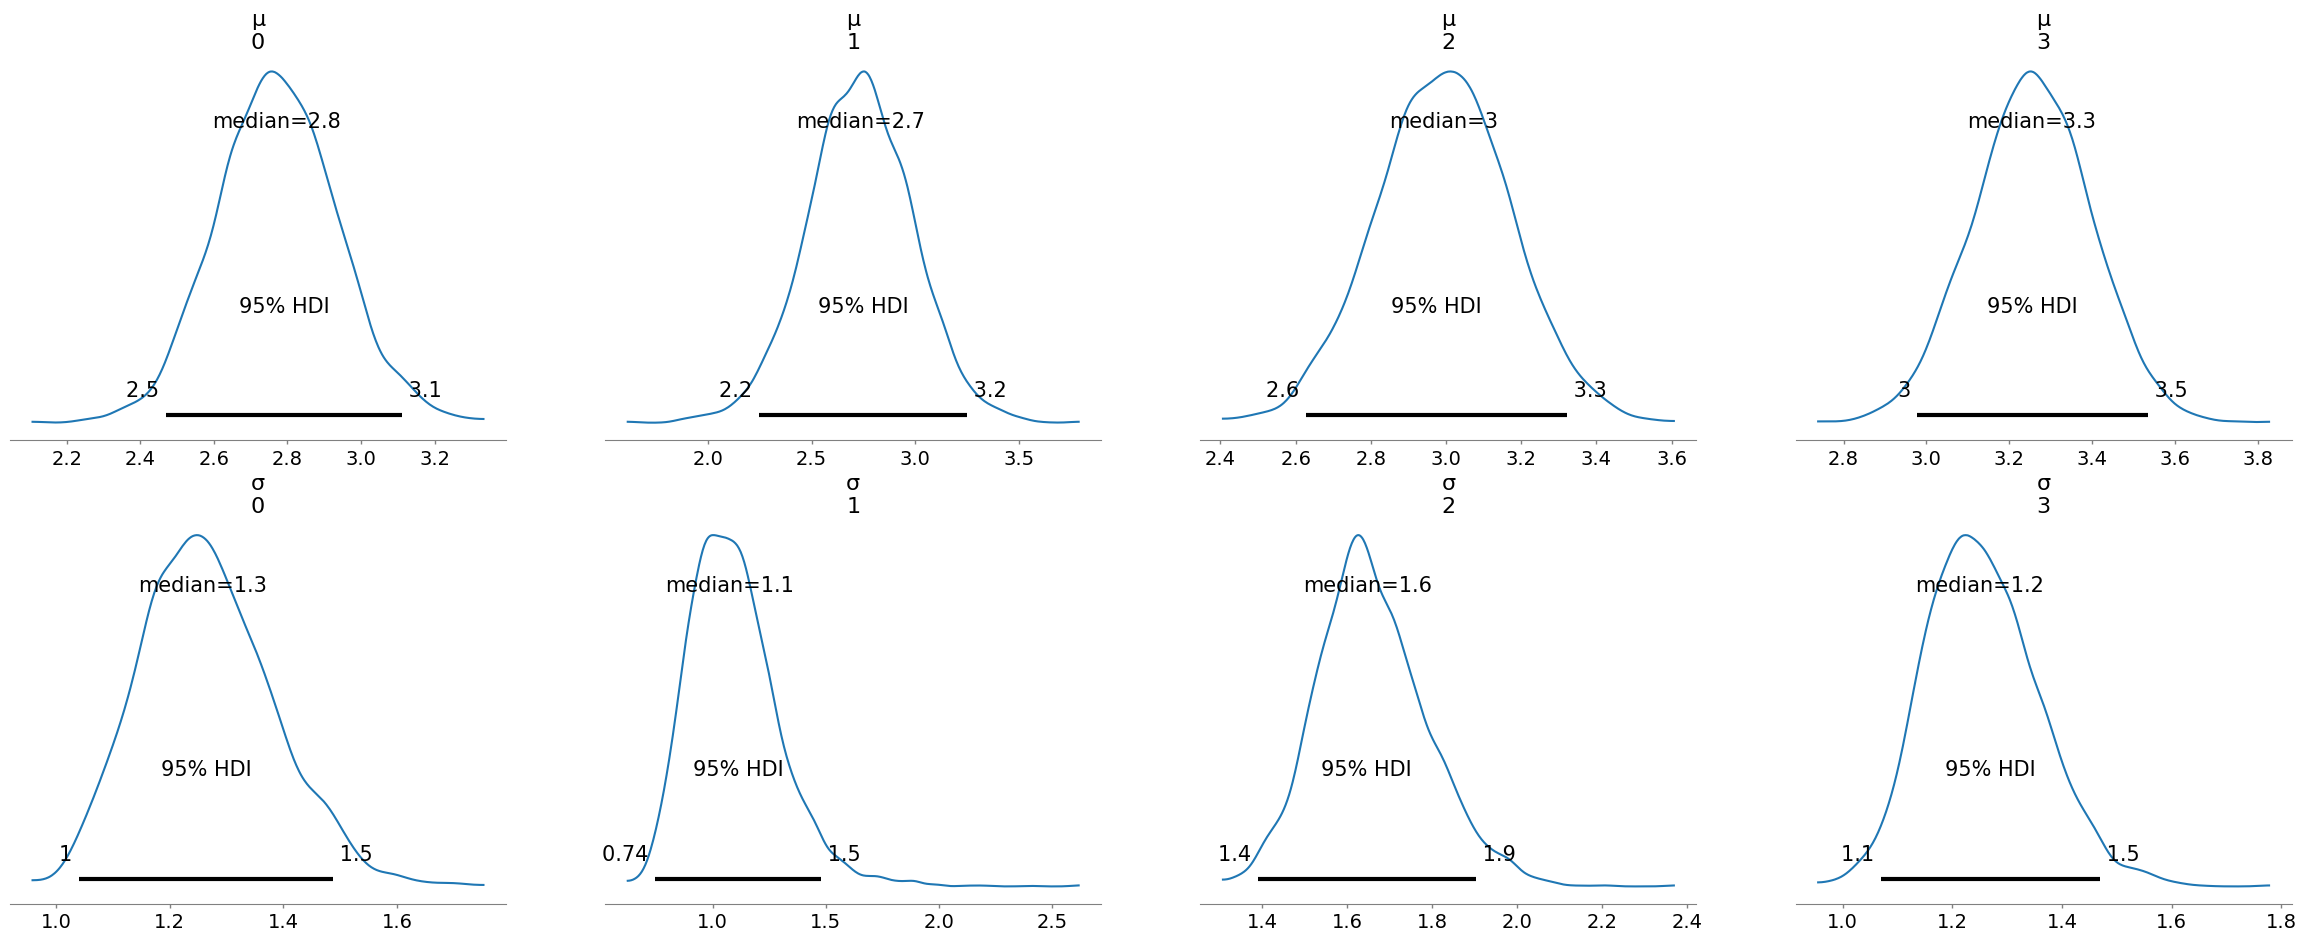

In [8]:
az.plot_posterior(trace_cg, point_estimate="median", hdi_prob=0.95)
plt.show()

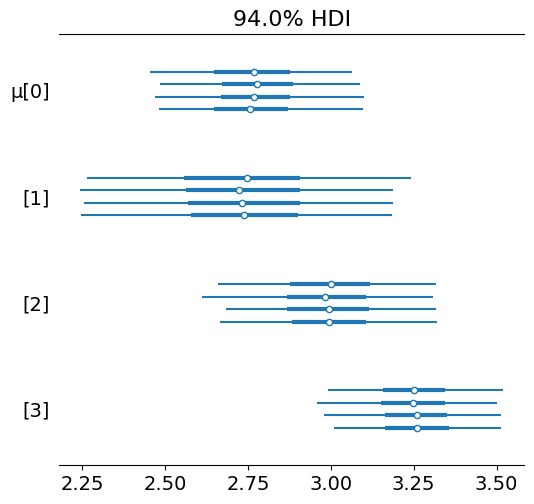

In [9]:
az.plot_forest(trace_cg, var_names=["μ"])
plt.show()

---
## Итоговое сравнение апостериорных распределений коэф-та Коэна

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


/opt/homebrew/Caskroom/miniconda/base/envs/bayes/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,Pair,Mean Cohen's d,Median Cohen's d,HDI 95% Low,HDI 95% High,Probability > 0,Effect Size
0,Fri vs Sat,-0.185,-0.187,-0.623,0.268,0.194,Small
1,Fri vs Sun,-0.444,-0.447,-0.937,0.052,0.042,Small
2,Fri vs Thur,-0.031,-0.031,-0.540,0.463,0.450,Small
3,Sat vs Sun,-0.178,-0.175,-0.488,0.125,0.117,Small
4,Sat vs Thur,0.152,0.152,-0.169,0.468,0.828,Small
5,Sun vs Thur,0.386,0.383,0.055,0.720,0.988,Small


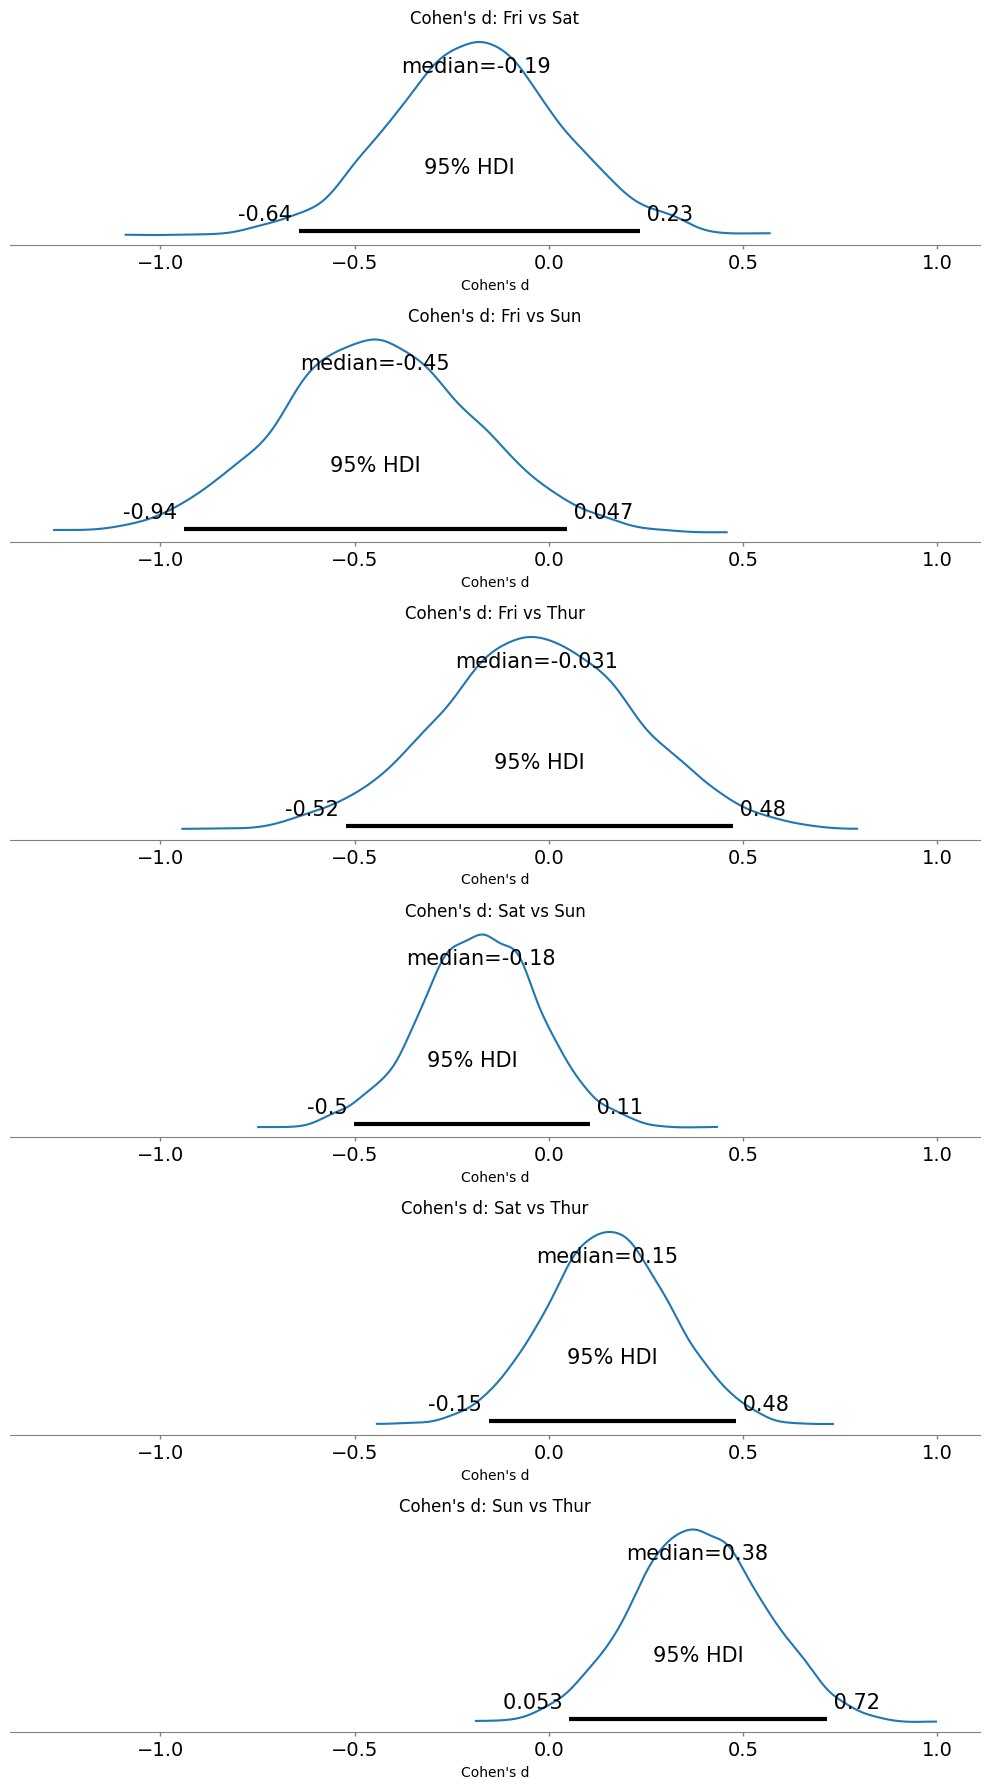

In [10]:
# Подготовим данные
tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=np.unique(tips["day"])).codes
groups = len(np.unique(idx))
group_names = np.unique(tips["day"])


# Байесовская модель
with pm.Model() as model:
    μ = pm.Normal("μ", mu=0, sigma=10, shape=groups)
    σ = pm.HalfNormal("σ", sigma=10, shape=groups)
    y = pm.Normal("y", mu=μ[idx], sigma=σ[idx], observed=tip)

    trace = pm.sample(1000, tune=1000)
   
# Получение апостериорных выборок 
mu_samples = trace.posterior["μ"].values  # shape = (chains, draws, groups)
sigma_samples = trace.posterior["σ"].values

# Объединяем цепочки
mu_samples_flat = mu_samples.reshape(-1, groups)     # shape = (total_draws, groups)
sigma_samples_flat = sigma_samples.reshape(-1, groups)

# Динамическое вычисление всех пар групп
# Все уникальные пары групп
pairs = list(itertools.combinations(range(groups), 2))

# Для хранения результатов
cohens_d_dict = {}

for i, j in pairs:
    mu_i = mu_samples_flat[:, i]
    mu_j = mu_samples_flat[:, j]
    sigma_i = sigma_samples_flat[:, i]
    sigma_j = sigma_samples_flat[:, j]

    cohens_d = (mu_i - mu_j) / np.sqrt((sigma_i**2 + sigma_j**2) / 2)
    cohens_d_dict[f"{group_names[i]} vs {group_names[j]}"] = cohens_d

# Вывод статистик в виде таблицы
results = []

for pair, d_values in cohens_d_dict.items():
    mean = np.mean(d_values)
    median = np.median(d_values)
    hdi_low, hdi_high = np.percentile(d_values, [2.5, 97.5])
    results.append({
        "Pair": pair,
        "Mean Cohen's d": mean,
        "Median Cohen's d": median,
        "HDI 95% Low": hdi_low,
        "HDI 95% High": hdi_high,
        "Probability > 0": np.mean(d_values > 0),
        "Effect Size": "Large" if abs(mean) > 0.8 else "Medium" if abs(mean) > 0.5 else "Small"
    })

results_df = pd.DataFrame(results).round(3)
display(results_df)

# Визуализация апостериорных распределений
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, 3 * len(pairs)), sharex=True)

if len(pairs) == 1:
    axes = [axes]

group_names_list = list(group_names)

for ax, (pair_key, d_values) in zip(axes, cohens_d_dict.items()):
    # Восстанавливаем i, j из названия группы
    name_i, name_j = pair_key.split(" vs ")
    i = group_names_list.index(name_i)
    j = group_names_list.index(name_j)

    az.plot_posterior(d_values, point_estimate="median", hdi_prob=0.95, ax=ax)
    ax.set_title(f"Cohen's d: {group_names[i]} vs {group_names[j]}")
    ax.set_xlabel("Cohen's d")

plt.tight_layout()
plt.show()